In [1]:
import os
import numpy as np
import itertools
import torch
import copy
import random
import csv
import sys
import json
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from datetime import datetime
from transformers import (
    PreTrainedModel,
    BertTokenizer,
    BertModel,
    AdamW,
    BertConfig,
    BertForSequenceClassification,
    DataProcessor,
    InputExample,
    glue_convert_examples_to_features,
)
from tqdm import tqdm_notebook, trange, tqdm
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

## Parameters

In [36]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = {
    "save_results_path": 'outputs',
    "pretrain_dir": 'models',
    "bert_model": "/fred/oz064/xcai/paper1/pytorch/huggingface/bert-base-uncased",
    "max_seq_length": None,
    "feat_dim": 768,
    "warmup_proportion": 0.1,
    "freeze_bert_parameters": True,
    "save_model": True,
    "save_results": True,
    "dataset": "oos",
    "known_cls_ratio": 0.75,
    "labeled_ratio": 1.0,
    "method": None,
    "seed": 0,
    "gpu_id": '0',
    "lr": 2e-5,
    "num_train_epochs": 100.0,
    "train_batch_size": 128,
    "eval_batch_size": 64,
    "wait_patient": 10,
    "lr_boundary": 0.05,
    "num_labels": 10,
}
args = dotdict(args)

## Data Loader

In [2]:
data_path = '../data/data_full.json'
def data_read(data_path):
    reader = []
    with open (data_path) as f:
        reader = json.load(f)
    return reader      
data_read(data_path).keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [3]:
# data generation
train_data = data_read(data_path)["train"]
val_data = data_read(data_path)["val"]
test_data = data_read(data_path)["test"]
oos_train_data = data_read(data_path)["oos_train"]
oos_val_data = data_read(data_path)["oos_val"]
oos_test_data = data_read(data_path)["oos_test"]

# data label generation
def label_generator(train_data, oos_train_data):
    data_label = []
    for index in range(0,len(train_data)) :
        if train_data[index][1] not in data_label:
            data_label.append(train_data[index][1])
            index = index + 1
    data_label.append(oos_train_data[0][1])
    return data_label
idx_to_type = label_generator(train_data, oos_train_data)
print(idx_to_type)

['translate', 'transfer', 'timer', 'definition', 'meaning_of_life', 'insurance_change', 'find_phone', 'travel_alert', 'pto_request', 'improve_credit_score', 'fun_fact', 'change_language', 'payday', 'replacement_card_duration', 'time', 'application_status', 'flight_status', 'flip_coin', 'change_user_name', 'where_are_you_from', 'shopping_list_update', 'what_can_i_ask_you', 'maybe', 'oil_change_how', 'restaurant_reservation', 'balance', 'confirm_reservation', 'freeze_account', 'rollover_401k', 'who_made_you', 'distance', 'user_name', 'timezone', 'next_song', 'transactions', 'restaurant_suggestion', 'rewards_balance', 'pay_bill', 'spending_history', 'pto_request_status', 'credit_score', 'new_card', 'lost_luggage', 'repeat', 'mpg', 'oil_change_when', 'yes', 'travel_suggestion', 'insurance', 'todo_list_update', 'reminder', 'change_speed', 'tire_pressure', 'no', 'apr', 'nutrition_info', 'calendar', 'uber', 'calculator', 'date', 'carry_on', 'pto_used', 'schedule_maintenance', 'travel_notifica

In [12]:
# len(oos_train_data)

In [5]:
# class DatasetProcessor(DataProcessor):

# #     def get_examples(self, data_dir, mode):
# #         if mode == 'train':
# #             return self._create_examples(
# #                 self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")
# #         elif mode == 'eval':
# #             return self._create_examples(
# #                 self._read_tsv(os.path.join(data_dir, "dev.tsv")), "train")
# #         elif mode == 'test':
# #             return self._create_examples(
# #                 self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

# #     def get_labels(self, data_dir):
# #         """See base class."""
# #         import pandas as pd
# #         test = pd.read_csv(os.path.join(data_dir, "train.tsv"), sep="\t")
# #         labels = np.unique(np.array(test['label']))
            
# #         return label
    
#     def _create_examples(self, lines, set_type):
#         """Creates examples for the training and dev sets."""
#         examples = []
#         for (i, line) in enumerate(lines):
#             if i == 0:
#                 continue
#             if len(line) != 2:
#                 continue
#             guid = "%s-%s" % (set_type, i)
#             text_a = line[0]
#             label = line[1]

#             examples.append(
#                 InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
#         return examples

# def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
#     """Loads a data file into a list of `InputBatch`s."""
#     label_map = {}
#     for i, label in enumerate(label_list):
#         label_map[label] = i

#     features = []
#     for (ex_index, example) in enumerate(examples):
#         tokens_a = tokenizer.tokenize(example.text_a)

#         tokens_b = None
#         if example.text_b:
#             tokens_b = tokenizer.tokenize(example.text_b)
#             # Modifies `tokens_a` and `tokens_b` in place so that the total
#             # length is less than the specified length.
#             # Account for [CLS], [SEP], [SEP] with "- 3"
#             _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
#         else:
#             # Account for [CLS] and [SEP] with "- 2"
#             if len(tokens_a) > max_seq_length - 2:
#                 tokens_a = tokens_a[:(max_seq_length - 2)]

#         # The convention in BERT is:
#         # (a) For sequence pairs:
#         #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
#         #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
#         # (b) For single sequences:
#         #  tokens:   [CLS] the dog is hairy . [SEP]
#         #  type_ids: 0   0   0   0  0     0 0
#         #
#         # Where "type_ids" are used to indicate whether this is the first
#         # sequence or the second sequence. The embedding vectors for `type=0` and
#         # `type=1` were learned during pre-training and are added to the wordpiece
#         # embedding vector (and position vector). This is not *strictly* necessary
#         # since the [SEP] token unambigiously separates the sequences, but it makes
#         # it easier for the model to learn the concept of sequences.
#         #
#         # For classification tasks, the first vector (corresponding to [CLS]) is
#         # used as as the "sentence vector". Note that this only makes sense because
#         # the entire model is fine-tuned.
#         tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
#         segment_ids = [0] * len(tokens)

#         if tokens_b:
#             tokens += tokens_b + ["[SEP]"]
#             segment_ids += [1] * (len(tokens_b) + 1)

#         input_ids = tokenizer.convert_tokens_to_ids(tokens)

#         # The mask has 1 for real tokens and 0 for padding tokens. Only real
#         # tokens are attended to.
#         input_mask = [1] * len(input_ids)

#         # Zero-pad up to the sequence length.
#         padding = [0] * (max_seq_length - len(input_ids))
#         input_ids += padding
#         input_mask += padding
#         segment_ids += padding

#         assert len(input_ids) == max_seq_length
#         assert len(input_mask) == max_seq_length
#         assert len(segment_ids) == max_seq_length

#         label_id = label_map[example.label]
#         # if ex_index < 5:
#         #     logger.info("*** Example ***")
#         #     logger.info("guid: %s" % (example.guid))
#         #     logger.info("tokens: %s" % " ".join(
#         #         [str(x) for x in tokens]))
#         #     logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
#         #     logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
#         #     logger.info(
#         #         "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
#         #     logger.info("label: %s (id = %d)" % (example.label, label_id))

#         features.append(
#             InputFeatures(input_ids=input_ids,
#                           input_mask=input_mask,
#                           segment_ids=segment_ids,
#                           label_id=label_id))
#     return features

In [6]:
# train_data[0]

In [7]:
# train_data[0][0]

In [8]:
# train_data[0][1]

In [8]:
#InputExample(guid='0', text_a=train_data[0][0], label=train_data[0][1])
def create_examples(data):
    examples = []
    for i, e in enumerate(data):
        examples.append(InputExample(guid = str(i), text_a=e[0], label=e[1]))
    return examples

In [9]:
examples = create_examples(train_data)
print(examples[:3])

[InputExample(guid='0', text_a='what expression would i use to say i love you if i were an italian', text_b=None, label='translate'), InputExample(guid='1', text_a="can you tell me how to say 'i do not speak much spanish', in spanish", text_b=None, label='translate'), InputExample(guid='2', text_a="what is the equivalent of, 'life is good' in french", text_b=None, label='translate')]


In [93]:
def generate_dataloaders(tokenizer, data_path):
    def generate_dataloader_inner(examples, data_type='train'):
        features = glue_convert_examples_to_features(
            examples,
            tokenizer,
            label_list = idx_to_type,
            max_length = 64,
            output_mode = 'classification'
        )
        
        dataset = torch.utils.data.TensorDataset(
            torch.LongTensor([f.input_ids for f in features]),
            torch.LongTensor([f.attention_mask for f in features]),
            torch.LongTensor([f.token_type_ids for f in features]),
            torch.LongTensor([f.label for f in features])   
        )
        if data_type == 'train':
            sampler = torch.utils.data.RandomSampler(dataset)
        else:
            sampler = torch.utils.data.SequentialSampler(dataset)
        dataloader = torch.utils.data.DataLoader(
            dataset, sampler = sampler, batch_size = 32
        )
        return dataloader
    
    # notice here class OOS is always the last label
    train_examples = create_examples(data_read(data_path)["train"]+ data_read(data_path)["oos_train"])
    print('Load Example Finish')
    train_loader = generate_dataloader_inner(train_examples, data_type='train')
    print('Generate DataLoader Finish')

    valid_examples = create_examples(data_read(data_path)["val"] + data_read(data_path)["oos_val"])
    print('Load Example Finish')
    valid_loader = generate_dataloader_inner(valid_examples, data_type='valid')
    print('Generate DataLoader Finish')   
    
    return train_loader, valid_loader

In [94]:
bert_path = "/fred/oz064/xcai/paper1/pytorch/huggingface/bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_path)
train_loader, valid_loader = generate_dataloaders(tokenizer, data_path)

Load Example Finish
Generate DataLoader Finish
Load Example Finish
Generate DataLoader Finish


In [102]:
for batch in valid_loader:
# for batch in train_loader:
    print(batch[3])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])
tensor([4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7])
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9])
tensor([ 9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11])
tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])
tensor([12, 12, 12, 12, 13, 13, 

In [126]:
def cos_loss(x, y, num_cls, w, 
             reuse=False, alpha=0.25, beta=0.25, scale=64, 
             lamb=0.05, name='cos_margin_loss'):
    '''
    x: B x D - features
    y: B - labels
    num_cls: 1 - total class number, the last cls being out of scope
    w: num_cls x D - mean feature vectors (centroids)
    alpah: 1 - in scope margin
    beta: 1 - out of scope margin
    scale: 1 - scaling paramter
    ''' 
    #normalize the feature and weight
    #(B,D)
    x_feat_norm = F.normalize(x,p=2,dim=1,eps=1e-12)
    #(D,num_cls)
    w_feat_norm = torch.transpose(F.normalize(w,p=2,dim=1,eps=1e-12), 0, 1)

    # get the scores after normalization 
    #(B,num_cls)
    xw_norm = torch.matmul(x_feat_norm, w_feat_norm)  # cosine similarity

    # xbj's loss, first row, adjust the cosine similarity by a margin, only apply to in-scope instances
    xw_norm[:, :-1] -= alpha #(B,num_cls)
#     xw_norm[:, -1] -= alpha #(B,num_cls)

    # margin based softmax loss
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    ce_loss = loss_fn(xw_norm, y)
    ce_loss[y == 150] = 0
#     print("ce_loss shape: ", ce_loss.shape)
    
    # xbj loss, second row, only applies to out of scope instances
    out_of_scope_loss_part2 = torch.max(xw_norm[:, :-1] - alpha, dim=1)[0] - xw_norm[:, -1]
    out_of_scope_loss_part2[out_of_scope_loss_part2 < 0] = 0
#     print("out_of_scope_loss_part2 shape: ", out_of_scope_loss_part2.shape)
    out_of_scope_loss = lamb * (1 - xw_norm[:, -1]) + out_of_scope_loss_part2
#     print("out_of_scope_loss shape: ", out_of_scope_loss.shape)
       
    out_of_scope_loss[y < 150] = 0
    
    loss = torch.mean(ce_loss + out_of_scope_loss)
    
    return loss 

def predict(x, w, alpha=0.25):
    '''
    x: B x D - features
    w: num_cls x D - mean feature vectors (centroids)
    ''' 
    #normalize the feature and weight
    #(B,D)
#     print("x.size():", x.size())
    x_feat_norm = F.normalize(x,p=2,dim=1,eps=1e-12)
    #(D,num_cls)
    w_feat_norm = torch.transpose(F.normalize(w,p=2,dim=1,eps=1e-12), 0, 1)

    # get the scores after normalization 
    #(B,num_cls)
    xw_norm = torch.matmul(x_feat_norm, w_feat_norm)  # cosine similarity

    xw_norm[:, :-1] -= alpha
    
    preds = xw_norm.max(1)[1]
    
    return preds

In [15]:
# torch.__version__

In [ ]:
# class BERTModel (pl.LightningModule):
    
#     def __init__(self,
#                  pretrained_path,
#                  train_loader,
#                  valid_loader):
#         super(BERTModel, self).__init__()
#         self.train_loader = train_loader
#         self.valid_loader = valid_loader
        
#         config = BertConfig.from_json_file(pretrained_path + '/config.json')
#         config.num_labels = len(idx_to_type)
#         print(config)
        
#         # pretrained model
#         self.ptm = BertForSequenceClassification.from_pretrained(
#             os.path.join(retrained_path, 'pytorch_model.bin')
#             config = config
#         )
        
#         # loss function
#         self.criterion = DCMLLoss()
        
#     def forward(self, input_ids, attention_mask, token_type_ids):
#         return self.ptm(
#             input_ids = input_ids,
#             attention_mask = attention_mask,
#             token_type_ids = token_type_ids   
#         )[0]
    
#     def training_step(self, batch, batch_idx):
#         input_ids, attention
        

In [37]:
bert_model = BertModel.from_pretrained(args.bert_model)
def get_optimizer(bert_model, args):
    param_optimizer = list(bert_model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters,
                     lr = args.lr)   
    return optimizer
optimizer = get_optimizer(bert_model, args)
    
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id           
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [84]:
def compute_centroids(dataloader, bert_model):
    print("Computing centroids...")
    vectors = []
    all_labels = []
    with torch.no_grad():
        for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)
            outputs = bert_model(input_ids, attention_mask, token_type_ids)
            pooler_output = outputs.pooler_output
            vectors.append(pooler_output.cpu())
            all_labels.append(labels.cpu())
    vectors = torch.cat(vectors, 0) # num_ins, feature_dim
    labels = torch.cat(all_labels, 0) # num_ins
    w = []
    for i in range(151):
        w.append(vectors[labels==i].mean(0, keepdim=True))
    w = torch.cat(w, 0)
    return w
w = compute_centroids(valid_loader, bert_model)

Computing centroids...


In [86]:
w = w.detach().to(DEVICE)

In [ ]:
! mkdir checkpoints

In [129]:
for epoch in range(100):  # loop over the dataset multiple times

    w = compute_centroids(train_loader, bert_model).detach().to(DEVICE)
    last_w = w.cpu()
    
    running_loss = 0.0
    
    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        token_type_ids = token_type_ids.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = bert_model(input_ids, attention_mask, token_type_ids)
        pooler_output  = outputs.pooler_output 
#         print("y.size():", y.size())
        
        loss = cos_loss(pooler_output, labels, 151, w, alpha=0.25, beta=0.25, scale=64, name='cos_margin_loss')
#         print(loss.item())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss / (i+1)))
    evaluate(valid_loader, last_w)
    
print('Finished Training')
bert_model.save_pretrained("checkpoints/")

Computing centroids...
[1] loss: 4.078
accuracy:  0.8651612903225806 out of scope recall:  0.77 out of scope precision:  0.2862453531598513
all_recalls:  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.85, 0.85, 1.0, 1.0, 1.0, 1.0, 0.9, 0.0, 1.0, 1.0, 1.0, 0.95, 0.3, 0.9, 1.0, 1.0, 1.0, 0.95, 1.0, 0.85, 0.65, 1.0, 0.75, 0.95, 1.0, 0.8, 1.0, 0.9, 1.0, 0.8, 1.0, 0.75, 1.0, 1.0, 0.8, 0.9, 0.95, 0.95, 0.85, 1.0, 1.0, 0.95, 0.95, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.9, 1.0, 0.95, 1.0, 1.0, 0.95, 0.3, 0.95, 0.85, 1.0, 1.0, 1.0, 0.9, 0.8, 0.0, 0.95, 1.0, 0.55, 0.0, 1.0, 0.0, 1.0, 1.0, 0.65, 1.0, 0.75, 0.85, 1.0, 0.85, 0.95, 1.0, 0.3, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.95, 1.0, 0.7, 0.8, 0.9, 1.0, 0.9, 0.95, 0.45, 0.95, 0.95, 1.0, 0.95, 0.85, 0.95, 0.95, 1.0, 1.0, 0.0, 1.0, 0.95, 1.0, 1.0, 0.95, 0.0, 1.0, 0.65, 1.0, 0.85, 1.0, 0.95, 0.9, 1.0, 0.95, 0.55, 0.6, 1.0, 1.0, 0.95, 0.95, 0.6, 1.0, 1.0, 0.9, 0.95, 1.0, 0.85, 0.95, 1.0, 0.95]
Computing centroids...
[2] loss: 4.071
accurac

[10] loss: 4.043
accuracy:  0.91 out of scope recall:  0.71 out of scope precision:  0.45222929936305734
all_recalls:  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 0.8, 0.9, 1.0, 0.95, 1.0, 1.0, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 0.7, 0.9, 0.8, 0.95, 1.0, 0.95, 1.0, 0.9, 0.95, 1.0, 0.8, 0.95, 1.0, 0.8, 1.0, 0.95, 0.95, 0.85, 1.0, 0.9, 1.0, 1.0, 0.85, 0.95, 0.95, 1.0, 0.85, 1.0, 1.0, 0.95, 1.0, 0.85, 0.95, 1.0, 1.0, 1.0, 1.0, 0.6, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 0.95, 0.8, 1.0, 1.0, 1.0, 0.75, 0.0, 1.0, 0.0, 1.0, 1.0, 0.85, 1.0, 0.95, 1.0, 0.9, 0.8, 0.85, 1.0, 0.7, 1.0, 1.0, 0.85, 0.95, 1.0, 1.0, 0.95, 0.95, 0.9, 0.8, 0.85, 1.0, 0.9, 0.95, 0.95, 1.0, 0.9, 1.0, 1.0, 1.0, 0.95, 0.9, 1.0, 1.0, 0.95, 1.0, 0.8, 1.0, 1.0, 1.0, 0.0, 1.0, 0.95, 0.9, 0.8, 1.0, 0.95, 0.75, 0.95, 0.95, 0.55, 0.7, 1.0, 0.85, 1.0, 0.8, 0.95, 1.0, 1.0, 1.0, 0.9, 1.0, 0.95, 0.95, 1.0, 0.95]
Computing centroids...
[11] loss: 4.041
accuracy:  0.9083870967741936 out of scope rec

[19] loss: 4.028
accuracy:  0.905483870967742 out of scope recall:  0.59 out of scope precision:  0.4125874125874126
all_recalls:  [0.95, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.75, 0.9, 0.95, 0.95, 1.0, 1.0, 0.95, 0.9, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9, 0.8, 1.0, 1.0, 0.95, 1.0, 0.85, 1.0, 1.0, 0.8, 0.95, 1.0, 0.9, 1.0, 0.9, 0.95, 0.85, 1.0, 0.9, 1.0, 0.95, 0.85, 0.95, 0.95, 1.0, 0.85, 1.0, 1.0, 0.9, 1.0, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 0.95, 0.8, 1.0, 0.95, 1.0, 0.95, 0.0, 1.0, 0.0, 1.0, 1.0, 0.85, 0.95, 1.0, 1.0, 0.9, 0.5, 0.9, 1.0, 0.85, 1.0, 1.0, 0.7, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 0.85, 0.8, 1.0, 0.9, 0.95, 0.95, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 0.9, 1.0, 0.6, 1.0, 1.0, 0.9, 0.0, 1.0, 1.0, 0.85, 0.95, 1.0, 0.8, 0.9, 0.9, 0.95, 0.75, 0.7, 1.0, 0.85, 1.0, 0.9, 0.95, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0, 0.95, 1.0, 0.95]
Computing centroids...
[20] loss: 4.027
accuracy:  0.9012903225806451 out of s

[28] loss: 4.020
accuracy:  0.8938709677419355 out of scope recall:  0.58 out of scope precision:  0.41134751773049644
all_recalls:  [0.95, 1.0, 1.0, 0.95, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9, 1.0, 1.0, 1.0, 1.0, 0.95, 0.8, 0.95, 1.0, 0.95, 1.0, 0.65, 0.9, 0.8, 0.95, 1.0, 0.95, 1.0, 0.85, 1.0, 1.0, 0.8, 0.95, 1.0, 0.9, 1.0, 0.85, 0.5, 0.85, 1.0, 0.9, 1.0, 0.95, 0.85, 0.9, 0.95, 1.0, 0.85, 1.0, 1.0, 0.95, 1.0, 0.85, 0.95, 1.0, 1.0, 1.0, 1.0, 0.15, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.9, 0.0, 1.0, 0.0, 1.0, 1.0, 0.9, 0.95, 1.0, 1.0, 0.9, 0.4, 1.0, 1.0, 0.8, 1.0, 1.0, 0.85, 0.95, 0.95, 1.0, 0.95, 0.95, 0.95, 0.8, 0.85, 1.0, 0.9, 0.95, 0.95, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 0.85, 1.0, 1.0, 0.9, 1.0, 0.8, 1.0, 1.0, 0.9, 0.0, 1.0, 1.0, 0.85, 0.95, 1.0, 0.85, 0.8, 0.9, 0.95, 0.35, 0.7, 1.0, 0.85, 1.0, 0.45, 0.95, 1.0, 1.0, 1.0, 0.75, 0.95, 1.0, 0.95, 1.0, 0.95]
Computing centroids...
[29] loss: 4.020
accuracy:  0.8919354838709678

[37] loss: 4.014
accuracy:  0.9061290322580645 out of scope recall:  0.56 out of scope precision:  0.5490196078431373
all_recalls:  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.85, 0.95, 0.95, 1.0, 1.0, 0.85, 0.95, 0.95, 1.0, 0.95, 1.0, 0.7, 0.9, 0.9, 0.95, 1.0, 0.9, 1.0, 0.85, 1.0, 1.0, 0.8, 0.95, 1.0, 0.9, 1.0, 0.85, 0.0, 0.85, 1.0, 0.95, 1.0, 0.95, 0.85, 0.9, 0.95, 1.0, 0.85, 1.0, 1.0, 1.0, 1.0, 0.8, 0.95, 1.0, 1.0, 1.0, 1.0, 0.85, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 0.95, 0.8, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.85, 1.0, 0.95, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 0.6, 1.0, 0.5, 1.0, 1.0, 0.8, 0.95, 1.0, 1.0, 0.95, 0.95, 0.95, 0.85, 0.9, 1.0, 0.9, 0.95, 0.95, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 0.35, 1.0, 1.0, 0.95, 1.0, 0.85, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.85, 0.95, 1.0, 0.85, 0.95, 0.9, 1.0, 0.5, 0.65, 1.0, 0.85, 1.0, 0.2, 0.95, 1.0, 1.0, 1.0, 0.9, 0.95, 1.0, 0.95, 1.0, 0.9]
Computing centroids...
[38] loss: 4.014
accuracy:  0.9045161290322581 ou

[46] loss: 4.011
accuracy:  0.9077419354838709 out of scope recall:  0.52 out of scope precision:  0.5473684210526316
all_recalls:  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0.75, 0.85, 1.0, 0.95, 1.0, 1.0, 0.8, 0.95, 0.95, 1.0, 0.95, 1.0, 0.7, 0.9, 0.85, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.8, 0.95, 1.0, 0.85, 1.0, 0.8, 0.95, 0.85, 1.0, 0.85, 1.0, 0.95, 0.85, 0.9, 0.95, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.8, 0.95, 1.0, 1.0, 1.0, 1.0, 0.65, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 0.95, 0.8, 0.95, 1.0, 1.0, 0.9, 1.0, 1.0, 0.95, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 0.9, 0.95, 1.0, 0.65, 0.95, 1.0, 0.95, 0.95, 0.95, 1.0, 0.95, 0.95, 0.95, 0.85, 0.9, 1.0, 0.9, 0.95, 1.0, 1.0, 0.95, 1.0, 0.95, 1.0, 1.0, 0.75, 1.0, 1.0, 0.95, 1.0, 0.6, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.85, 0.9, 1.0, 1.0, 0.95, 0.9, 0.95, 0.45, 0.7, 1.0, 0.85, 1.0, 0.35, 0.95, 1.0, 1.0, 1.0, 0.65, 0.95, 0.85, 0.95, 0.95, 0.95]
Computing centroids...


KeyboardInterrupt: 

In [130]:
bert_model.save_pretrained("checkpoints/")

In [132]:
np.savetxt("checkpoints/last_w.txt", last_w.numpy())

In [161]:
def evaluate(dataloder, w):
    w = w.to(DEVICE)
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloder):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = bert_model(input_ids, attention_mask, token_type_ids)
            pooler_output  = outputs.pooler_output 

            preds = predict(pooler_output, w, alpha=0.25).cpu()
            all_preds.append(preds)
            all_labels.append(labels)
            
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    accuracy = torch.sum(preds == labels).item() / labels.shape[0]
    
    all_recalls = [torch.sum(preds[labels==i] == labels[labels==i]).item() / torch.sum(labels == i).item() for i in range(150)]
    out_of_scope_recall = torch.sum(preds[labels==150] == labels[labels==150]).item() / torch.sum(labels == 150).item()
    out_of_scope_precision = torch.sum(preds[labels==150] == labels[labels==150]).item() / torch.sum(preds == 150).item()
    in_scope_accuracy = torch.sum(preds[labels<150] == labels[labels<150]).item() / torch.sum(labels < 150).item()
    
    print("accuracy: ", accuracy, "out of scope recall: ", out_of_scope_recall, "out of scope precision: ", out_of_scope_precision)
    print("all_recalls: ", all_recalls)
    print("in_scope_accuracy: ", in_scope_accuracy)
evaluate(valid_loader, last_w)

accuracy:  0.9064516129032258 out of scope recall:  0.28 out of scope precision:  0.9333333333333333
all_recalls:  [1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.55, 1.0, 1.0, 0.75, 0.85, 1.0, 0.95, 1.0, 1.0, 0.9, 0.85, 0.95, 1.0, 0.95, 1.0, 0.7, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.8, 0.95, 1.0, 0.85, 1.0, 0.8, 0.95, 0.85, 1.0, 0.85, 1.0, 0.95, 0.85, 0.9, 0.95, 1.0, 0.8, 1.0, 1.0, 0.95, 1.0, 0.8, 0.95, 1.0, 1.0, 1.0, 1.0, 0.05, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 0.95, 0.8, 0.95, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.9, 0.95, 1.0, 1.0, 1.0, 0.9, 0.85, 1.0, 1.0, 0.45, 0.95, 1.0, 0.8, 0.95, 0.95, 1.0, 0.95, 0.95, 0.95, 0.85, 0.9, 1.0, 0.9, 0.95, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 0.9, 1.0, 1.0, 0.95, 1.0, 0.85, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 0.85, 0.9, 1.0, 0.85, 0.95, 0.9, 0.95, 0.75, 0.7, 1.0, 0.85, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.5, 0.95, 0.85, 0.95, 0.95, 0.95]
in_scope_accuracy:  0.9273333333333333


In [131]:
w

tensor([[ 0.3153, -0.9144,  0.9559,  ..., -0.9560, -0.7603,  0.9861],
        [-0.1153,  0.2655,  0.6013,  ...,  0.5308,  0.5777, -0.5683],
        [-0.9282,  0.9458,  0.9965,  ...,  0.9924,  0.5375, -0.9541],
        ...,
        [ 0.3962, -0.9217,  0.6195,  ..., -0.9755, -0.1495,  0.6169],
        [ 0.9736,  0.9740, -0.9233,  ...,  0.1658,  0.8475, -0.9853],
        [-0.9185, -0.6664, -0.9901,  ..., -0.9873, -0.8145,  0.5749]],
       device='cuda:0')

# Visualization

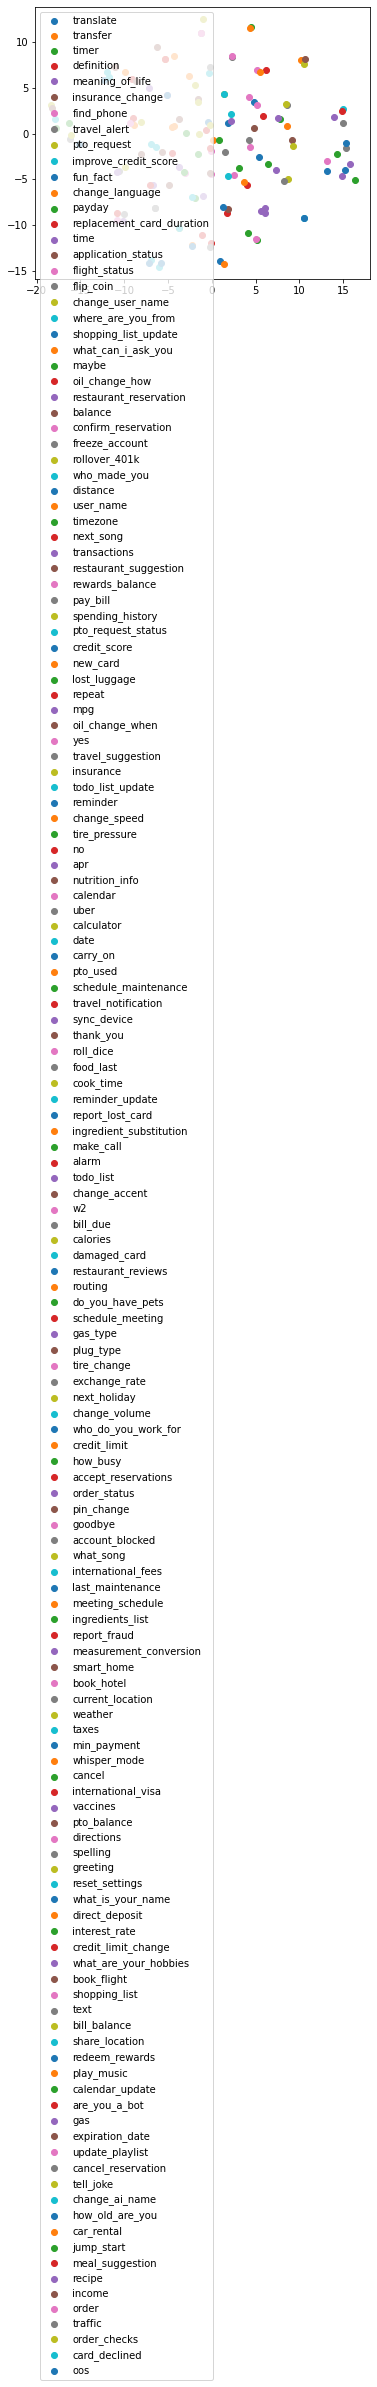

In [136]:
%matplotlib inline
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(last_w.numpy())

target_ids = range(len(idx_to_type))


plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, idx_to_type):
    plt.scatter(X_2d[i, 0], X_2d[i, 1], label=label)
plt.legend()
plt.show()

In [145]:
def predict_for_visualization(dataloder, w):
    w = w.to(DEVICE)
    all_labels = []
    all_vectors = []
    with torch.no_grad():
        for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloder):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            token_type_ids = token_type_ids.to(DEVICE)

            # forward + backward + optimize
            outputs = bert_model(input_ids, attention_mask, token_type_ids)
            pooler_output  = outputs.pooler_output 

            all_vectors.append(pooler_output)
            all_labels.append(labels)
            
    labels = torch.cat(all_labels)
    vectors = torch.cat(all_vectors, 0)
    
    return labels.cpu().numpy(), vectors.cpu().numpy()
labels, vectors = predict_for_visualization(train_loader, last_w)

In [154]:
vectors.shape
vectors_and_weights = np.concatenate([vectors, last_w.numpy()], 0)

In [155]:
vectors_and_weights.shape

(15251, 768)

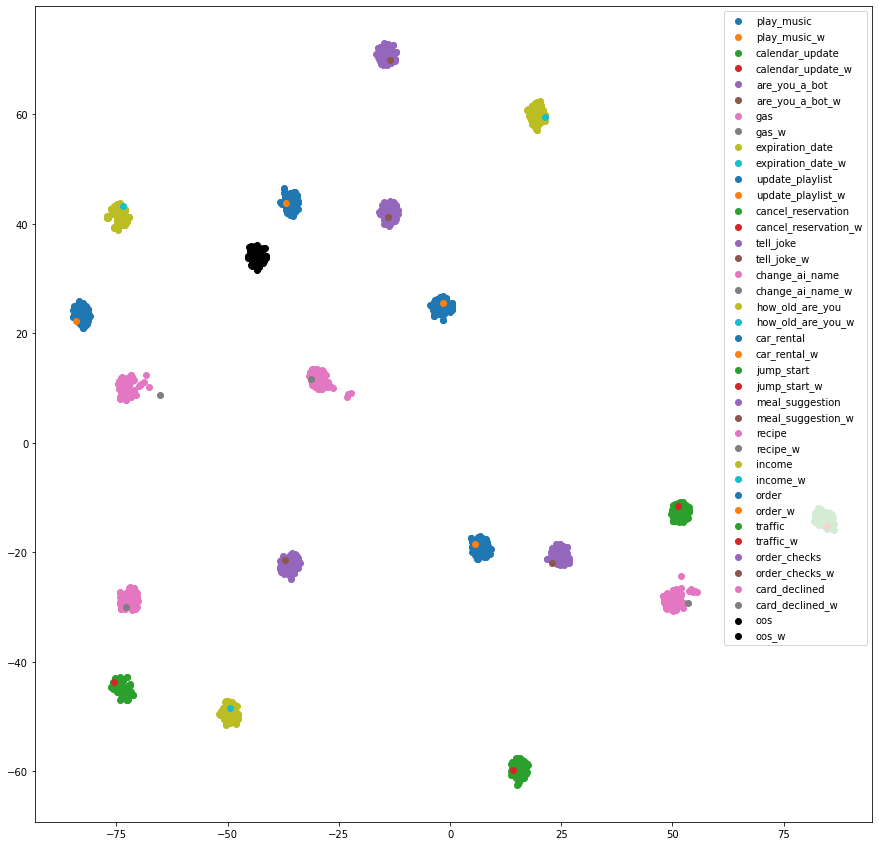

In [158]:
%matplotlib inline
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(vectors_and_weights)

target_ids = range(len(idx_to_type[:]))
X_2d_vectors = X_2d[:-151]
X_2d_w = X_2d[-151:]

plt.figure(figsize=(15, 15))
for i, label in zip(target_ids, idx_to_type[:]):
    if i == 150:
        plt.scatter(X_2d_vectors[labels==i, 0], X_2d_vectors[labels==i, 1], c='k', label=label)
        plt.scatter(X_2d_w[i, 0], X_2d_w[i, 1], c='k', label=label+"_w")
    elif i > 130:
        plt.scatter(X_2d_vectors[labels==i, 0], X_2d_vectors[labels==i, 1], label=label)
        plt.scatter(X_2d_w[i, 0], X_2d_w[i, 1], label=label+"_w")
plt.legend()
plt.show()